In [26]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import operator
import seaborn as sns


In [27]:
palette = list(sns.color_palette("colorblind",4))
palette.extend(list([sns.color_palette("colorblind",10)[-4]]))
palette.extend(list(sns.color_palette("colorblind",10)[-2::]))
palette


[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

### Plot Confusion Matrices

In [2]:
valid_phones = ['ao', 'ae', 'r', 'eh', 't', 'b', 'aa', 'f', 'k', 'ng', 's', 'g', 'ow', 'er', 'l', 'th', 'z', 'aw', 'd', 'dh', 'sh', 'hh', 'iy', 'ch', 'm', 'ey', 'v', 'y', 'zh', 'jh', 'p', 'uw', 'ah', 'w', 'n', 'oy', 'ay', 'ih', 'uh']

In [3]:
def create_matrix(layer,accent):
    f = open('confusion_{}_{}.json'.format(layer,accent), 'r+')
    confusion = json.load(f)
    #print(confusion)
    conf_list = np.zeros((39,39), dtype= float)
    for k,v in confusion.items():
        #print(k)
        for p, val in v.items():
        #print(k,p,val)
        #print(valid_phones.index(k),valid_phones.index(p))
            conf_list[valid_phones.index(k)][valid_phones.index(p)] = val
    row_sums = conf_list.sum(axis = 1)
    normalized_conf  = conf_list / row_sums[:, np.newaxis]
    return normalized_conf

In [4]:
def plot_confusion_matrix(layer, accent):
    normalized_conf = create_matrix(layer,accent)
    classNames = valid_phones
    tick_marks = np.arange(len(classNames))
    fig = plt.figure(figsize = (10,10))
    plt.xticks(tick_marks, classNames, rotation = 45,fontsize=12)
    plt.yticks(tick_marks, classNames,fontsize=12)
    plt.imshow(normalized_conf, cmap=mpl.cm.Reds)
    #plt.colorbar()
    
    plt.clim(0,1)
    fig.tight_layout()
    plt.title('Confusion Matrix for layer: {} , Accent: {}'.format(layer.upper(),accent.capitalize()), fontsize=24)
    plt.savefig('../../Final Submission/Repo/ASR-Accent-Analysis/PhoneProbes/ConfusionMatrices/{}/Conf_{}_{}.png'.format(accent,layer,accent),bbox_inches='tight')
    #plt.show()
        
    
    

In [20]:
accents = ['us','canada','indian','african','australia','england','scotland']
layers = ['spec', 'conv', 'rnn_0', 'rnn_1', 'rnn_2', 'rnn_3', 'rnn_4']
for layer in layers:
    #print('########## Accent {} ##########'.format(accent))
    for accent in accents:
        plot_confusion_matrix(layer, accent)
        
    


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


In [5]:
def cross_entropy(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

# predictions = np.array([[0.25,0.25,0.25,0.25],
#                         [0.01,0.01,0.01,0.96]])
# targets = np.array([[0,0,0,1],
#                    [0,0,0,1]])
# ans = 0.71355817782  #Correct answer
# x = cross_entropy(predictions, targets)
# print(x)
# print(np.isclose(x,ans))

In [6]:
def print_top_conf(layer,accent):
    matrix = create_matrix(layer,accent)
    baseline = np.eye(39)
    revised = matrix*(np.ones((39,39))-baseline)
    values = []
    for i in range(39):
        for j in range(39):
            if(i !=j): values.append(matrix[i][j])
    mean = np.mean(values)
    std = np.std(values)
    cross_entropies = []
    #print(revised)
    #print(mean,std)
    selected = {}
    for i in range(39):
        for j in range(39):
            if(revised[i][j] > mean + 3*std): 
                selected[str(valid_phones[i])+'-'+str(valid_phones[j])] = revised[i][j]

    sorted_dict = sorted(selected.items(), key=operator.itemgetter(1), reverse=True)
    print(accent, sorted_dict[:10])
# for i in range(39):
#     cross_entropies.append(cross_entropy(matrix[i],baseline[i] ))
# print(cross_entropies)


In [22]:
def print_high_entropy(layer,accent):
    matrix = create_matrix(layer,accent)
    baseline = np.eye(39)
    revised = matrix*(np.ones((39,39))-baseline)
    values = []
    for i in range(39):
        for j in range(39):
            if(i !=j): values.append(matrix[i][j])
    mean = np.mean(values)
    std = np.std(values)
    cross_entropies = []
    #print(revised)
    #print(mean,std)
    selected = {}
    for i in range(39):
        ce = cross_entropy(matrix[i], matrix[i])
    
        selected[valid_phones[i]] = ce
        cross_entropies.append(ce)
#     for i in range(39):
#         for j in range(39):
#             if(revised[i][j] > mean + 3*std): 
#                 selected[str(valid_phones[i])+'-'+str(valid_phones[j])] = revised[i][j]
    #print(selected)

    sorted_dict = sorted(selected.items(), key=operator.itemgetter(1), reverse=True)
#     print(accent, sorted_dict[:10])
#     print(np.mean(cross_entropies))
    return np.mean(cross_entropies)
# for i in range(39):
#     cross_entropies.append(cross_entropy(matrix[i],baseline[i] ))
# print(cross_entropies)


In [23]:
accents = ['us','canada','indian','african','australia','england','scotland']
layers = ['spec', 'conv', 'rnn_0', 'rnn_1', 'rnn_2', 'rnn_3', 'rnn_4']
entropy = {k:[] for k in accents}
for accent in accents:
    for layer in layers:
        entropy[accent].append(print_high_entropy(layer,accent))
print(entropy)

{'england': [0.05377503326630798, 0.06011876186995684, 0.055512647677087884, 0.04903368802228237, 0.043722013175751286, 0.04094668808516729, 0.041053606964216505], 'indian': [0.05352189722289811, 0.061860777036296055, 0.0574093929578202, 0.052524345605190134, 0.048922879385055205, 0.0488640603643088, 0.04939871716699779], 'us': [0.056600580347769644, 0.05820187734855617, 0.052031870449020336, 0.04527213504806636, 0.039090835328966345, 0.03629536365666775, 0.035627245788733365], 'african': [0.0576112752950394, 0.058663986442912305, 0.05189809907643993, 0.046124337877469355, 0.04043740274347687, 0.038522557084751954, 0.03897400947703812], 'canada': [0.05626358359508505, 0.05638944276275977, 0.04881086627504738, 0.041810009976201636, 0.0355409343136112, 0.03324885719961412, 0.03262689801042943], 'scotland': [0.05703482181773236, 0.05937201559912353, 0.054532491904063604, 0.05052320036893158, 0.046341899427911656, 0.045229380062139155, 0.04657141971157265], 'australia': [0.0556064219495274

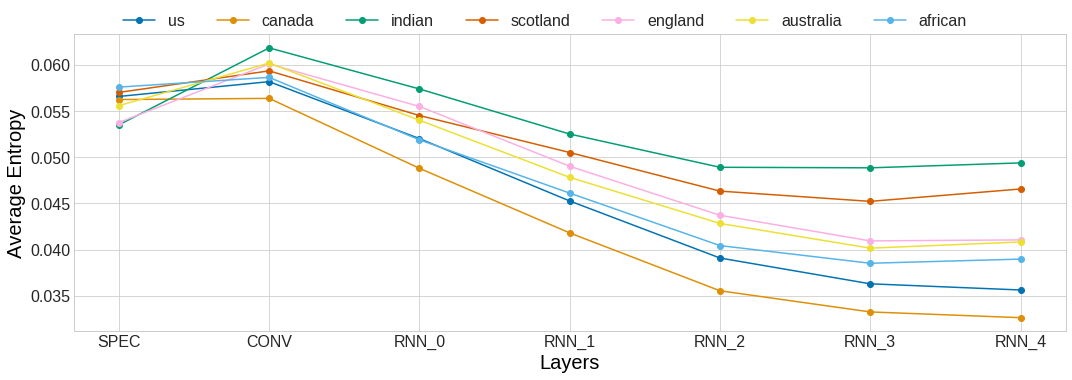

In [35]:
objects = ['spec','conv', 'rnn_0', 'rnn_1', 'rnn_2', 'rnn_3', 'rnn_4']
objects_u = [x.upper() for x in objects]
y_pos = np.arange(len(objects))
fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=palette)
plt.style.use('seaborn-whitegrid')
plt.plot(y_pos, entropy['us'],'-o', alpha=1, label = 'us', linewidth = 1.5)
plt.plot(y_pos, entropy['canada'], '-o',alpha=1, label = 'canada', linewidth = 1.5)
plt.plot(y_pos, entropy['indian'], '-o',alpha=1, label= 'indian', linewidth = 1.5)
plt.plot(y_pos, entropy['scotland'], '-o',alpha=1, label= 'scotland', linewidth = 1.5)
plt.plot(y_pos, entropy['england'], '-o',alpha=1, label = 'england', linewidth = 1.5)
plt.plot(y_pos, entropy['australia'], '-o',alpha=1, label = 'australia', linewidth = 1.5)
plt.plot(y_pos, entropy['african'], '-o',alpha=1, label = 'african', linewidth = 1.5)

plt.xticks(y_pos, objects_u,fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel('Average Entropy',color='k', fontsize=20)
plt.xlabel('Layers',color='k', fontsize=20)

legend = plt.legend(fontsize=16,frameon=False,loc='upper center', bbox_to_anchor=(0.475, 1.12),
          ncol=7, fancybox=True, shadow=True)
#plt.grid()

fig.tight_layout()
plt.savefig('entropy.pdf',bbox_inches='tight')
plt.show()


In [25]:
accents = ['us','canada','indian','african','australia','england','scotland']
for accent in accents:
    print_top_conf('rnn_4',accent)
    #print('\n')

us [('aa-ao', 0.1339712918660287), ('zh-jh', 0.125), ('z-s', 0.11221294363256785), ('aa-ah', 0.10909090909090909), ('g-k', 0.09259259259259259), ('ch-sh', 0.08668730650154799), ('zh-sh', 0.08333333333333333), ('zh-z', 0.08333333333333333), ('uh-k', 0.08042895442359249), ('ng-n', 0.07561929595827901)]
canada [('zh-ah', 0.11764705882352941), ('zh-v', 0.08823529411764706), ('g-k', 0.07355242566510173), ('th-t', 0.07157464212678936), ('y-uw', 0.07022900763358779), ('ch-t', 0.06896551724137931), ('er-r', 0.06867196367763904), ('aa-ao', 0.06242905788876277), ('z-s', 0.06190476190476191), ('ng-ih', 0.05975609756097561)]
indian [('zh-ah', 0.3793103448275862), ('th-t', 0.26244343891402716), ('z-s', 0.17490283176013327), ('uh-uw', 0.15354330708661418), ('er-ah', 0.15282623866015352), ('zh-iy', 0.13793103448275862), ('ch-t', 0.1359773371104816), ('g-k', 0.12965722801788376), ('d-t', 0.12773403324584426), ('aa-ah', 0.11804008908685969)]
african [('z-s', 0.10248447204968944), ('ae-ah', 0.0983397190

### Change Distrubution of Phones

In [13]:
mix = {'n': 0.029333333333333333, 'w': 0.034666666666666665, 'q': 0.013333333333333334, 'aa': 0.02666666666666667, 'z': 0.010666666666666666, 'er': 0.018666666666666668, 'th': 0.0026666666666666666, 'f': 0.018666666666666668, 'ay': 0.013333333333333334, 'r': 0.048, 'ah': 0.013333333333333334, 'dx': 0.013333333333333334, 'em': 0.0026666666666666666, 'dh': 0.016, 'ey': 0.016, 's': 0.056, 'ch': 0.013333333333333334, 'ux': 0.0026666666666666666, 'sh': 0.013333333333333334, 't': 0.08266666666666667, 'm': 0.024, 'oy': 0.0026666666666666666, 'eh': 0.021333333333333333, 'ae': 0.016, 'l': 0.042666666666666665, 'b': 0.04, 'pau': 0.010666666666666666, 'g': 0.021333333333333333, 'el': 0.005333333333333333, 'uw': 0.005333333333333333, 'ih': 0.024, 'uh': 0.005333333333333333, 'en': 0.005333333333333333, 'jh': 0.008, 'ix': 0.048, 'iy': 0.042666666666666665, 'v': 0.010666666666666666, 'ax': 0.04266666666666667, 'hh': 0.005333333333333333, 'k': 0.055999999999999994, 'y': 0.0026666666666666666, 'p': 0.029333333333333336, 'ao': 0.02666666666666667, 'd': 0.021333333333333333, 'epi': 0.008, 'nx': 0.010666666666666666, 'ow': 0.016, 'ng': 0.0026666666666666666}
mix2 = {k:1 for k in mix.keys()}

In [14]:
def mixture(layer, accent):
    f = open('confusion_{}_{}.json'.format(layer,accent), 'r+')
    confusion = json.load(f)
    conf_list = np.zeros((39,39), dtype= float)
    for k,v in confusion.items():
            #print(k)
            for p, val in v.items():
            #print(k,p,val)
            #print(valid_phones.index(k),valid_phones.index(p))
                conf_list[valid_phones.index(k)][valid_phones.index(p)] = val
    row_sums = conf_list.sum(axis = 1)
    normalized_conf  = conf_list / row_sums[:, np.newaxis]
    accuracy = {}
    for p in valid_phones:
        p_idx = valid_phones.index(p)
        accuracy[p] = normalized_conf[p_idx][p_idx]
    overall = 0
    total_mix = 0

    for p in valid_phones:
        if p not in mix.keys():
            #print(p)
            continue
        overall += accuracy[p]*mix[p] 
        total_mix += mix[p]
    return 100*overall/total_mix


In [15]:
layers = ['spec', 'conv', 'rnn_0', 'rnn_1', 'rnn_2', 'rnn_3', 'rnn_4']
accents = ['us', 'canada', 'indian', 'scotland', 'african','australia', 'england']
final = {}
for accent in accents:
    accent_l = []
    for layer in layers:
        accent_l.append(mixture(layer,accent))
    final[accent] = accent_l
        


In [16]:
print(final)

{'australia': [23.882295786573977, 40.78649086376827, 52.12412804434393, 60.08082494289764, 65.63090422312813, 68.47256208897413, 68.38197960567067], 'scotland': [24.989233448726548, 41.07233760533532, 50.08588897601144, 56.78134294704093, 61.57004643478668, 63.527129107482416, 62.69628429556018], 'canada': [27.24499630487268, 46.11097761121334, 57.46418283302521, 66.48617943037304, 73.46193070804743, 75.4186165202351, 76.26660853853309], 'us': [25.924799327602496, 43.73741576267092, 54.39733301160252, 62.9184109263565, 69.64706350773255, 72.45295598379782, 72.99207990439862], 'indian': [20.500553276845217, 36.318168901795026, 45.59810031580054, 52.66461085154507, 57.29573164394779, 58.163587934135016, 57.08111626729552], 'england': [23.322689223131185, 39.98607629674601, 49.69668606472542, 57.20639924890041, 64.21994208951006, 67.72707793306387, 67.75636556337237], 'african': [23.415052030622867, 43.48734563485598, 54.148734159533916, 61.872968075575145, 67.28519083167093, 69.72188426

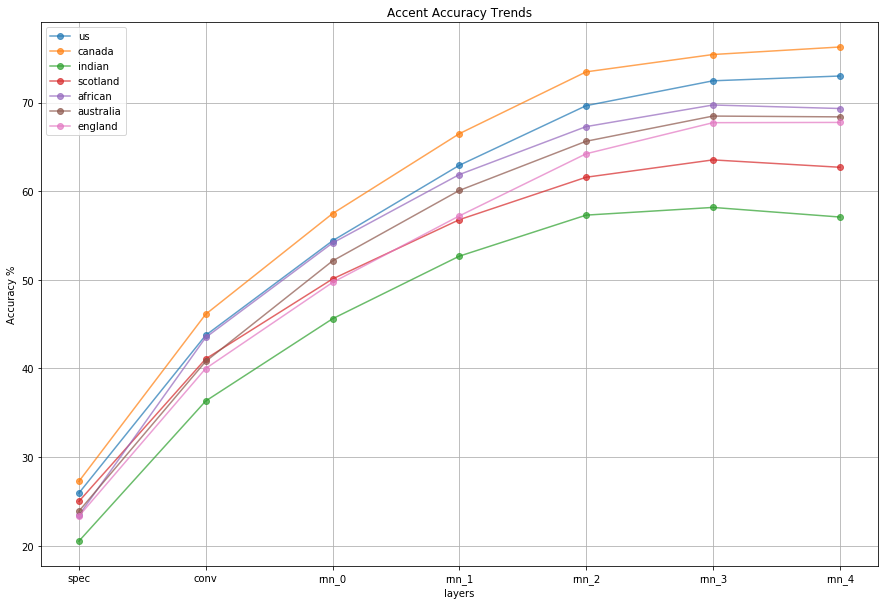

In [17]:
objects = ['spec', 'conv', 'rnn_0', 'rnn_1', 'rnn_2', 'rnn_3', 'rnn_4']
#objects.sort()
        #print()
y_pos = np.arange(len(objects))
fig = plt.figure(figsize = (15,10))
for accent in accents:
    plt.plot(y_pos, final[accent],'-o', alpha=0.7, label =accent)
# plt.plot(y_pos, us,'-o', alpha=0.7, label = 'us')
# plt.plot(y_pos, can, '-o',alpha=0.7, label = 'canada')
# plt.plot(y_pos, ind, '-o',alpha=0.7, label= 'indian')
# plt.plot(y_pos, scot, '-o',alpha=0.7, label= 'scotland')
# plt.plot(y_pos, eng, '-o',alpha=0.7, label = 'england')
# plt.plot(y_pos, aus, '-o',alpha=0.7, label = 'australia')
# plt.plot(y_pos, afri, '-o',alpha=0.7, label = 'african')
plt.xticks(y_pos, objects)
#plt.ylim(ymin = 0)
#plt.axhline(14.28, linewidth=1, color='k')
plt.grid()
plt.ylabel('Accuracy %')
plt.xlabel('layers')
plt.title('Accent Accuracy Trends')
plt.legend()
plt.show()